## Install libraries and import utilities

In [1]:
!pip install torch torchvision matplotlib

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
import torch 
import torchvision
import matplotlib.pyplot as plt

## Global parameters

In [3]:
# params
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
log_interval = 10

seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(seed)

FILES_DIR = "./files"

In [4]:
def create_transformer():
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

In [5]:
def create_dataloader(transformer):
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(FILES_DIR, train=True, download=True, transform=transformer),
        batch_size=batch_size_train,
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(FILES_DIR, train=False, download=True, transform=transformer),
        batch_size=batch_size_test,
        shuffle=True
    )
    return train_loader, test_loader

In [6]:
def inspect_dataset(dataloader):
    examples = enumerate(dataloader)
    batch_idx, (example_data, example_targets) = next(examples)

    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])
    fig

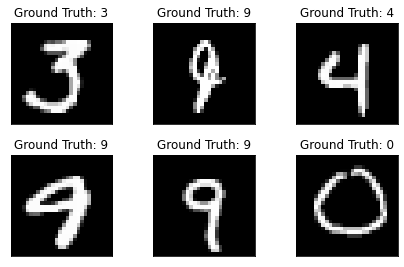

In [7]:
transformer = create_transformer()
train_loader, test_loader = create_dataloader(transformer)
inspect_dataset(test_loader)

## Model

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # 2 convolutional layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        # a dropout layer for generalization
        self.conv2_drop = nn.Dropout2d()

        # 2 fully connected layers for predictions
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # pass through first 2 convolutional layers with dropout
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten the image
        x = x.view(-1, 320)

        # pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        # softmax for probability output
        return F.log_softmax(x, dim=-1)

In [10]:
def create_trainer():
    network = Model()
    optimizer = optim.AdamW(network.parameters(), lr=learning_rate)
    return network, optimizer

In [11]:
network, optimizer = create_trainer()

In [12]:
def train(epoch):
    # set the network in training mode
    network.train()

    # for every batch of data, start optimizing
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        # negative log likelihood loss
        loss = F.nll_loss(output, target)
        # backprop
        loss.backward()
        # optimize params
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

In [13]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    # dont store any gradients info
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            # negative log likelihood loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
# evaluate with random first for baseline

test()

for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.071523
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.484514
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.273499
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.049928
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.918988
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.920614
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.896208
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.805277
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.991799
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.781642
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.919706
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.666805
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.803877
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.854080
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.693439
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.620413
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.945031
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.802691
Train Epoch: 1 [12160/6

## Test and save model

In [15]:
def inspect_network(dataloader):
    examples = enumerate(dataloader)
    batch_idx, (example_data, example_targets) = next(examples)
    with torch.no_grad():
        output = network(example_data)
        fig = plt.figure()
        for i in range(6):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
            plt.title("Prediction: {}".format(
                output.data.max(1, keepdim=True)[1][i].item()))
            plt.xticks([])
            plt.yticks([])
        fig

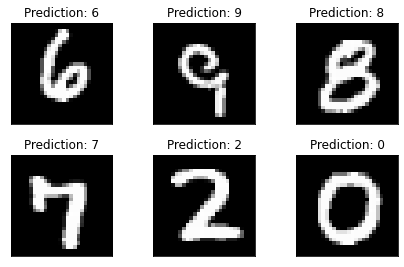

In [16]:
inspect_network(test_loader)

In [17]:
def export_network(name, network, dataloader):
    examples = enumerate(dataloader)
    batch_idx, (example_data, example_targets) = next(examples)
    torch.onnx.export(
        network,
        example_data,
        f"{name}.onnx",
        export_params=True,
        do_constant_folding=True,
        input_names = ['input'],
        output_names = ['output']
    )
    torch.save(network.state_dict(), f"{name}.pt")

In [18]:
export_network(FILES_DIR+"/original", network, test_loader)